# Import Libraries

In [1]:
import functools
import tracemalloc
import psutil
import os
from pathlib import Path
import time
import zipfile

import httpx
import dask.dataframe as dd
import seaborn as sns
from matplotlib import pyplot as plt

# Utilities

In [2]:
def profiler(func):
    """Decorator to measure memory usage and execution time of a function."""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        process = psutil.Process(os.getpid())

        # Start memory + time tracking
        start_mem = process.memory_info().rss / 1024**2
        tracemalloc.start()
        start_time = time.time()

        result = func(*args, **kwargs)  # run target function

        # After execution
        current, peak = tracemalloc.get_traced_memory()
        end_mem = process.memory_info().rss / 1024**2
        end_time = time.time()
        tracemalloc.stop()

        print(f"\n--- Memory Profile for `{func.__name__}` ---")
        print(f"Start memory   : {start_mem:.2f} MB")
        print(f"End memory     : {end_mem:.2f} MB")
        print(f"Peak (tracked) : {peak / 1024**2:.2f} MB")
        print(f"Execution time : {end_time - start_time:.2f} sec")
        print("------------------------------------------\n")

        return result
    return wrapper

In [3]:
# Constants

ROOT_PATH = Path(os.getcwd())
GDRIVE_ID = "1IXQDp8Um3d-o7ysZLxkDyuvFj9gtlxqz"
ARCHIVE_OUTPUT_PATH = ROOT_PATH / "dataset.zip"
DATASET_OUTPUT_PATH = ROOT_PATH / "customers-2000000.csv"

In [4]:
@profiler
def unzip_file(zip_path):
    # Check if the ZIP file exists
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"ZIP file not found: {zip_path}")
    
    # If no extraction directory specified, use the ZIP file's directory
    extract_to = "."
    
    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Successfully extracted {zip_path} to {extract_to}")
        
        # Optional: Print extracted files
        extracted_files = zip_ref.namelist()
        print(f"Extracted {len(extracted_files)} files:")
        for file in extracted_files[:5]:  # Show first 5 files
            print(f"  - {file}")
        if len(extracted_files) > 5:
            print(f"  ... and {len(extracted_files) - 5} more files")
    
    return os.path.abspath(extract_to)


@profiler
def load_data(file_path: Path, **kwargs) -> dd.DataFrame:
    return dd.read_csv(file_path, **kwargs)

# EDA

## Data Loading

In [ ]:
# Data Loading
!gdown 1IXQDp8Um3d-o7ysZLxkDyuvFj9gtlxqz -O dataset.zip

In [ ]:
# Unzip File
unzip_file(ARCHIVE_OUTPUT_PATH)

In [5]:
# Data Parsing
df = load_data(DATASET_OUTPUT_PATH, index_col=False)
df = df.set_index("Index")


--- Memory Profile for `load_data` ---
Start memory   : 169.54 MB
End memory     : 173.22 MB
Peak (tracked) : 1.16 MB
Execution time : 0.07 sec
------------------------------------------



## Data Understanding

In [15]:
# Number of rows (requires computation)
nrows = df.shape[0].compute()

# Number of columns (fast, metadata only)
ncols = len(df.columns)

print((nrows, ncols))

(2000000, 11)


In [ ]:
df.head()

In [6]:
df.npartitions

5

## Data Cleaning and Preparation

In [7]:
# Parsing to date
@profiler
def parse_date(df: dd.DataFrame, col: str):
    df[col] = dd.to_datetime(df[col])

parse_date(df, "Subscription Date")


--- Memory Profile for `parse_date` ---
Start memory   : 295.46 MB
End memory     : 293.02 MB
Peak (tracked) : 0.07 MB
Execution time : 0.03 sec
------------------------------------------



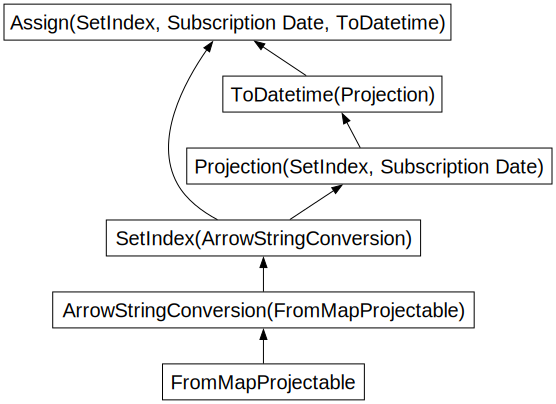

In [8]:
df.visualize()

In [17]:
df.head()

,Customer Id,First Name,Last Name,Company,City,Country,Phone 1,Phone 2,Email,Subscription Date,Website
Index,,,,,,,,,,,
1,4962fdbE6Bfee6D,Pam,Sparks,Patel-Deleon,Blakemouth,British Indian Ocean Territory (Chagos Archipe...,267-243-9490x035,480-078-0535x889,nicolas00@faulkner-kramer.com,2020-11-29,https://nelson.com/
2,9b12Ae76fdBc9bE,Gina,Rocha,"Acosta, Paul and Barber",East Lynnchester,Costa Rica,027.142.0940,+1-752-593-4777x07171,yfarley@morgan.com,2021-01-03,https://pineda-rogers.biz/
3,39edFd2F60C85BC,Kristie,Greer,Ochoa PLC,West Pamela,Ecuador,+1-049-168-7497x5053,+1-311-216-7855,jennyhayden@petty.org,2021-06-20,https://mckinney.com/
4,Fa42AE6a9aD39cE,Arthur,Fields,Moyer-Wang,East Belinda,Afghanistan,001-653-754-7486x65787,521-630-3858x953,igrimes@ruiz-todd.org,2020-02-13,https://dominguez.biz/
5,F5702Edae925F1D,Michelle,Blevins,Shah and Sons,West Jared,Marshall Islands,8735278329,(633)283-6034x500,diamondcarter@jordan.com,2020-10-20,http://murillo-ryan.com/
